# Problema 2: Datos sintéticos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Carga de los datos

In [2]:
x_train = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/x_entrenamiento.csv", header=None)
y_train = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/y_entrenamiento.csv", header=None)
x_val = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/x_validacion.csv", header=None)
y_val = pd.read_csv("~/Desktop/mcc20192/mlearning/tareas/tarea3/data/y_validacion.csv", header=None)

## a. Graficación de los datos


Text(0.5, 1.0, '$x$ vs $y$ on training set')

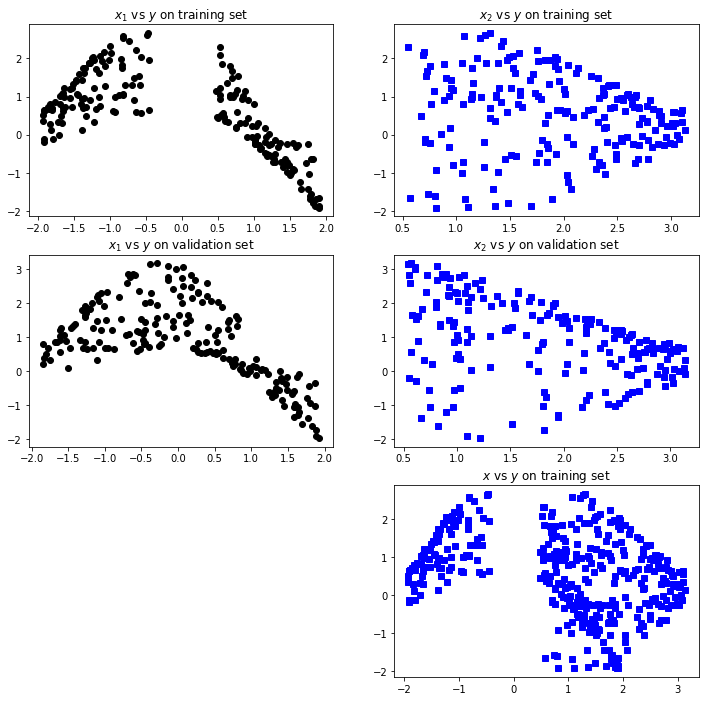

In [3]:
# Graficación de los datos
gs = plt.GridSpec(3,2)
fig = plt.figure(figsize=(12,12))
fig.tight_layout()

# Training data
fig.add_subplot(gs[0,0]).plot(x_train.values[0:,0],y_train.values[0:], 'ko')
plt.title("$x_1$ vs $y$ on training set")
fig.add_subplot(gs[0,1]).plot(x_train.values[0:,1],y_train.values[0:], 'bs')
plt.title("$x_2$ vs $y$ on training set")

fig.add_subplot(gs[1,0]).plot(x_val.values[0:,0],y_val.values[0:],'ko')
plt.title("$x_1$ vs $y$ on validation set")
fig.add_subplot(gs[1,1]).plot(x_val.values[0:,1],y_val.values[0:],'bs')
plt.title("$x_2$ vs $y$ on validation set")

fig.add_subplot(gs[2,1]).plot(x_train.values,y_train.values, 'bs')
plt.title("$x$ vs $y$ on training set")

## b. Regresión lineal 
Modelo $f(x,a) = a_0+a_1x_1+a_2x_2$. Hallar $a = (a_0,a_1,a_2)$ que minimiza la función de error
$$E(a)=\frac{1}{2}\sum _{i=0}^N(y_i-f(x^i,a))^2$$

## Training a linear regression

In [4]:
# Import my implementation of polynomial multiple regression see polynomialReg.py for details
from polynomialReg import *

# Call implementation of multiple polynomial regression with polynomial of degree 1 for a linear fitting
mlinear = polynomial_linreg(x_train.values,y_train.values,1)
mlinear.fit()

# Print coefficients of the fitted line
print(mlinear.a)

[[ 1.08332958]
 [-0.54618495]
 [-0.30062493]]


In [5]:
# Report the squares error for linear fitting on training set
print(mlinear.sqerror(x_train.values,y_train.values))

# Report the squares error for linear fitting on validation set
print(mlinear.sqerror(x_val.values,y_val.values))

7.6788652149734204
9.48014097536694


## c) Ridge regression with polynomials

In [76]:
from sklearn.linear_model import Ridge
from custom_routines import custom_routines as cr

alphas = np.logspace(-6, 3, 30)

In [77]:
# find best alpha and corresponding best degree among 1,...,10
# that gives the minimum error on validation set

train_best_param = np.ndarray(shape=(len(alphas),2))
val_best_param = np.ndarray(shape=(len(alphas),2))

train_results = np.zeros(12)
val_results = np.zeros(12)
count = 0

for a in alphas:
    polyRidge = Ridge(alpha = a)
    
    for d in range(0,12):
        # generate matrix model with polynomials of degree d+1
        Xd = cr.modelMatrix(x_train.values, d+1)
    
        # train ridge regression
        polyRidge.fit(Xd,y_train.values)
    
        # calculate error on training set
        train_results[d] = (cr.sqerror(polyRidge.predict(Xd),y_train.values))
    
        # calculate error on validation set
        Xd_val = cr.modelMatrix(x_val.values, d+1)
        val_results[d] = (cr.sqerror(polyRidge.predict(Xd_val),y_val.values))
        
    # Save best degree for given alpha on training set 
    train_best_param[count][0] = train_results.min()
    train_best_param[count][1] = train_results.argmin() + 1
    
    
    # Save best degree for given alpha on validation set   
    val_best_param[count][0] = val_results.min()
    val_best_param[count][1] = val_results.argmin() + 1
    count += 1

/home/erick/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.942338e-17
  overwrite_a=True).T
/home/erick/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.298146e-18
  overwrite_a=True).T
/home/erick/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.510062e-19
  overwrite_a=True).T
/home/erick/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal

Min error on training set: 2.6371751053383106 for alpha  1e-06 and degree  11.0
Min error on validation set: 3.257468522673425 for alpha  1e-06 and degree  7.0


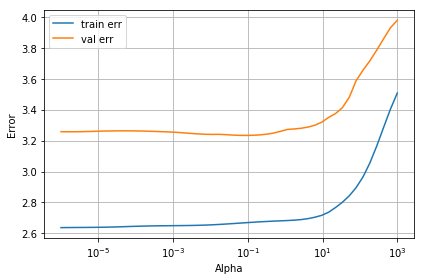

In [78]:
# Minimum error and degree in 1,..., 11 that ensures it 

train_alpha_min = train_best_param[0:][0].argmin()
print("Min error on training set:", train_best_param[train_alpha_min][0],  "for alpha ", 
      alphas[train_alpha_min], "and degree ", train_best_param[train_alpha_min][1])

val_alpha_min = val_best_param[0:][0].argmin()
print("Min error on validation set:", val_best_param[val_alpha_min][0],  "for alpha ", 
      alphas[val_alpha_min], "and degree ", val_best_param[val_alpha_min][1])

ax = plt.gca()
ax.plot(alphas, train_best_param[0:,0], label = "train err")
ax.plot(alphas, val_best_param[0:,0], label = "val err")

ax.set_xscale('log')
plt.legend()
plt.grid(True)
plt.ylabel("Error")
plt.xlabel("Alpha")
plt.tight_layout()
plt.show()

In [79]:
# model that minimizes error on validation set
bestmodel = Ridge(alpha=0.0001)
X7 = cr.modelMatrix(x_train.values,7)
X7_val = cr.modelMatrix(x_val.values,7)
bestmodel.fit(X7, y_train.values)
print(bestmodel.intercept_[0], bestmodel.coef_[0])
print(cr.sqerror(bestmodel.predict(X7),y_train.values))
print(cr.sqerror(bestmodel.predict(X7_val),y_val.values))

2.2967122949976586 [ 0.         -0.42045356 -1.30664161 -0.70372608  0.46185238  0.43849604
 -0.0835465  -0.07137465  0.42441127  1.73452713 -9.52052508 12.8446265
 -7.62356103  2.09716381 -0.2182857 ]
[2.72965105]
[3.26241267]


In [80]:
from sklearn import linear_model
linreg = linear_model.LinearRegression()
linreg.fit(x_train.values,y_train.values)
print(linreg.intercept_)
print(linreg.coef_)

# Función suma de errores cuadrados
def skl_sqerrors(x,y):
    s = 0.0
    xl = linreg.predict(x)
    for i in range(0,len(x)):
        s += (xl[i]-y[i][0])**2
    return np.sqrt(s/2)

print("Error on test set with linreg:", skl_sqerrors(x_val.values,y_val.values))

[1.08332958]
[[-0.54618495 -0.30062493]]
Error on test set with linreg: [9.48014098]
